In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("sales_data_2015.csv")

C:\Users\folke\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84768 entries, 0 to 84767
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  84768 non-null  int64  
 1   Sale_id     84768 non-null  int64  
 2   bbl_id      84768 non-null  int64  
 3   year        84768 non-null  int64  
 4   borough     84768 non-null  int64  
 5   bldg_ctgy   84768 non-null  object 
 6   tax_cls_p   84765 non-null  object 
 7   block       84768 non-null  int64  
 8   lot         84768 non-null  int64  
 9   easmnt      1 non-null      object 
 10  bldg_cls_p  84765 non-null  object 
 11  address     84768 non-null  object 
 12  apt         20983 non-null  object 
 13  zip         84768 non-null  int64  
 14  res_unit    84768 non-null  int64  
 15  com_unit    84768 non-null  int64  
 16  tot_unit    84768 non-null  int64  
 17  land_sqft   84768 non-null  int64  
 18  tot_sqft    84768 non-null  int64  
 19  yr_built    84768 non-nul

In [4]:
df.head()

,Unnamed: 0,Sale_id,bbl_id,year,borough,bldg_ctgy,tax_cls_p,block,lot,easmnt,...,land_sqft,tot_sqft,yr_built,tax_cls_s,bldg_cls_s,sale_date,price,usable,long,lat
0,0,1,2290528,2015,2,01 ONE FAMILY DWELLINGS,1,2905,28,NaN,...,4750,2619,1899,1,A9,08-07-15,0,N,-73.901338,40.841229
1,1,2,2290528,2015,2,01 ONE FAMILY DWELLINGS,1,2905,28,NaN,...,4750,2619,1899,1,A9,08-07-15,0,N,-73.901338,40.841229
2,2,3,230352,2015,2,01 ONE FAMILY DWELLINGS,1,3035,2,NaN,...,1287,2528,1899,1,S1,12/18/2015,0,N,-73.898331,40.848648
3,3,4,2303936,2015,2,01 ONE FAMILY DWELLINGS,1,3039,36,NaN,...,2500,2452,1910,1,S1,08/18/2015,0,N,-73.893338,40.856136
4,4,5,2303936,2015,2,01 ONE FAMILY DWELLINGS,1,3039,36,NaN,...,2500,2452,1910,1,S1,07-01-15,400000,Y,-73.893338,40.856136


In [38]:
df.describe()

,Unnamed: 0,Sale_id,bbl_id,year,borough,block,lot,zip,res_unit,com_unit,tot_unit,land_sqft,tot_sqft,yr_built,tax_cls_s,price,long,lat
count,84768.000000,84768.000000,8.476800e+04,84768.0,84768.000000,84768.000000,84768.000000,84768.000000,84768.000000,84768.000000,84768.000000,8.476800e+04,8.476800e+04,84768.00000,84768.000000,8.476800e+04,84768.000000,84768.000000
mean,42383.500000,42384.500000,5.552786e+07,2015.0,2.815968,3922.271812,395.336342,10795.058430,2.206882,0.213842,2.482894,2.897186e+03,4.594859e+03,1799.28020,1.820144,1.138515e+06,-73.932756,40.713802
std,24470.558146,24470.558146,1.137808e+08,0.0,1.331564,3505.674705,671.917553,640.425751,33.803117,3.328458,34.129612,1.051146e+05,4.351070e+04,520.81237,0.961171,8.874043e+06,0.096322,0.076601
min,0.000000,1.000000,0.000000e+00,2015.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.00000,1.000000,0.000000e+00,-74.253512,40.499018
25%,21191.750000,21192.750000,1.195860e+06,2015.0,1.000000,1169.000000,22.000000,10065.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,1920.00000,1.000000,0.000000e+00,-73.981860,40.664866
50%,42383.500000,42384.500000,4.222320e+06,2015.0,3.000000,2657.000000,50.000000,11206.000000,1.000000,0.000000,1.000000,1.650000e+03,9.900000e+02,1940.00000,2.000000,3.500000e+05,-73.949712,40.721858
75%,63575.250000,63576.250000,4.130948e+07,2015.0,4.000000,5878.000000,1003.000000,11355.000000,2.000000,0.000000,2.000000,2.638250e+03,2.180000e+03,1965.00000,2.000000,7.585960e+05,-73.864184,40.763282
max,84767.000000,84768.000000,5.786011e+08,2015.0,5.000000,16322.000000,9117.000000,11694.000000,8759.000000,612.000000,8805.000000,2.930553e+07,8.942176e+06,2016.00000,4.000000,8.700000e+08,-73.700774,40.912869


In [9]:
df.columns

Index(['Unnamed: 0', 'Sale_id', 'bbl_id', 'year', 'borough', 'bldg_ctgy',
       'tax_cls_p', 'block', 'lot', 'easmnt', 'bldg_cls_p', 'address', 'apt',
       'zip', 'res_unit', 'com_unit', 'tot_unit', 'land_sqft', 'tot_sqft',
       'yr_built', 'tax_cls_s', 'bldg_cls_s', 'sale_date', 'price', 'usable',
       'long', 'lat'],
      dtype='object')

In [21]:
def split_building_class_0(building):
    x = building[0]
    return x

def split_building_class_1(building):
    y = building[1]
    return y

In [24]:
df['split_bldg_cls_0'] = df['bldg_cls_p'].apply(lambda building: split_building_class_0(str(building)))
df['split_bldg_cls_1'] = df['bldg_cls_p'].apply(lambda building: split_building_class_1(str(building)))

In [31]:
df['split_bldg_cls_2'] = df['bldg_cls_s'].apply(lambda building: split_building_class_0(str(building)))
df['split_bldg_cls_3'] = df['bldg_cls_s'].apply(lambda building: split_building_class_1(str(building)))

In [68]:
df2 = df[['borough', 'res_unit', 'com_unit', 'tot_unit', 'land_sqft', 'tot_sqft', 'yr_built', 'price']].copy()

In [69]:
df2 = df2[(df2.yr_built != 0) & (df2.tot_sqft != 0) & (df2.price != 0)]

In [70]:
X = df2.drop(columns=['price'])
Y = df2.price

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .20, random_state = 40)
X_train.shape, X_test.shape

((22968, 7), (5743, 7))

In [75]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

print('Train:', lr.score(X_train, y_train))
print('Test:', lr.score(X_test, y_test))

Train: 0.2441402138728933
Test: 0.26068975625021584


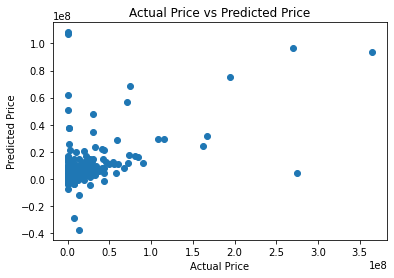

In [76]:
import matplotlib.pyplot as plt

plt.scatter(y_test, lr.predict(X_test))
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Price vs Predicted Price")
plt.show()

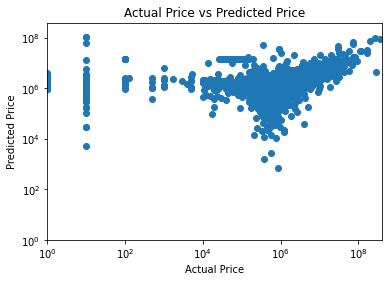

In [77]:
plt.scatter(y_test, lr.predict(X_test))
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Price vs Predicted Price")
plt.xlim(1,4e8)
plt.ylim(1,4e8)
plt.xscale('log')
plt.yscale('log')
plt.show()

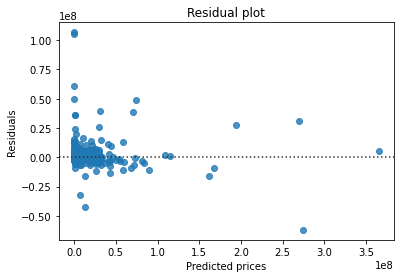

In [78]:
import seaborn

seaborn.residplot(y_test, lr.predict(X_test))
plt.xlabel("Predicted prices")
plt.ylabel("Residuals")
plt.title("Residual plot")
plt.show()